In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchsummary import summary

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

In [9]:
file_path = r"C:\Users\MinGi\Desktop\year3-sem1\인공지능개론\dataset\BP_data.csv"
df = pd.read_csv(file_path)

print(df.head())

   Patient_Number  Blood_Pressure_Abnormality  Level_of_Hemoglobin  \
0               1                           1                11.28   
1               2                           0                 9.75   
2               3                           1                10.79   
3               4                           0                11.00   
4               5                           1                14.17   

   Genetic_Pedigree_Coefficient  Age  BMI  Sex  Pregnancy  Smoking  \
0                          0.90   34   23    1        1.0        0   
1                          0.23   54   33    1        NaN        0   
2                          0.91   70   49    0        NaN        0   
3                          0.43   71   50    0        NaN        0   
4                          0.83   52   19    0        NaN        0   

   Physical_activity  salt_content_in_the_diet  alcohol_consumption_per_day  \
0              45961                     48071                          NaN   


In [15]:
print(df['Blood_Pressure_Abnormality'].value_counts(), "\n")
print(df.isnull().sum())

Blood_Pressure_Abnormality
0    1013
1     987
Name: count, dtype: int64 

Patient_Number                   0
Blood_Pressure_Abnormality       0
Level_of_Hemoglobin              0
Genetic_Pedigree_Coefficient     0
Age                              0
BMI                              0
Sex                              0
Pregnancy                        0
Smoking                          0
Physical_activity                0
salt_content_in_the_diet         0
alcohol_consumption_per_day      0
Level_of_Stress                  0
Chronic_kidney_disease           0
Adrenal_and_thyroid_disorders    0
dtype: int64


### 결측치 처리

In [16]:
df['Genetic_Pedigree_Coefficient'] = df['Genetic_Pedigree_Coefficient'].fillna(df['Genetic_Pedigree_Coefficient'].mean())
df['Pregnancy'] = df['Pregnancy'].fillna(df['Pregnancy'].mean())
df['alcohol_consumption_per_day'] = df['alcohol_consumption_per_day'].fillna(df['alcohol_consumption_per_day'].mean())

print(df.isnull().sum())

Patient_Number                   0
Blood_Pressure_Abnormality       0
Level_of_Hemoglobin              0
Genetic_Pedigree_Coefficient     0
Age                              0
BMI                              0
Sex                              0
Pregnancy                        0
Smoking                          0
Physical_activity                0
salt_content_in_the_diet         0
alcohol_consumption_per_day      0
Level_of_Stress                  0
Chronic_kidney_disease           0
Adrenal_and_thyroid_disorders    0
dtype: int64


### 입력/정답 나누기

In [17]:
x = df.drop('Blood_Pressure_Abnormality', axis=1).values
y = df['Blood_Pressure_Abnormality'].values
x, y

(array([[1.000e+00, 1.128e+01, 9.000e-01, ..., 2.000e+00, 1.000e+00,
         1.000e+00],
        [2.000e+00, 9.750e+00, 2.300e-01, ..., 3.000e+00, 0.000e+00,
         0.000e+00],
        [3.000e+00, 1.079e+01, 9.100e-01, ..., 2.000e+00, 1.000e+00,
         0.000e+00],
        ...,
        [1.998e+03, 1.691e+01, 2.200e-01, ..., 2.000e+00, 1.000e+00,
         1.000e+00],
        [1.999e+03, 1.115e+01, 7.200e-01, ..., 3.000e+00, 0.000e+00,
         1.000e+00],
        [2.000e+03, 1.136e+01, 9.000e-02, ..., 1.000e+00, 1.000e+00,
         0.000e+00]]),
 array([1, 0, 1, ..., 1, 0, 1], dtype=int64))

### 전처리

In [18]:
scaler = StandardScaler()
x = scaler.fit_transform(x)

### 원-핫 인코딩

In [19]:
Y = pd.get_dummies(y).values

### 훈련/테스트 나누기

In [20]:
x_train, x_test, y_train, y_test = train_test_split(x, Y,test_size=0.25,random_state=0)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(1500, 14) (1500, 2)
(500, 14) (500, 2)


### Pytorch로 변경

In [21]:
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.int64)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.int64)

### 데이터 로드 만들기

In [22]:
train_dataset = TensorDataset(x_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(x_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [23]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

(torch.Size([1500, 14]),
 torch.Size([500, 14]),
 torch.Size([1500, 2]),
 torch.Size([500, 2]))

### 모델 정의

In [28]:
class DiabetesDense(nn.Module):
    def __init__(self):
        super(DiabetesDense, self).__init__()
        self.fc1 = nn.Linear(14, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)  # raw output (logits)
        return x

# Initialize the model
model = DiabetesDense()

### 손실함수, 최적화함수 설정

In [29]:
criterion = nn.CrossEntropyLoss()  # classification을 위한 loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

### 모델 학습 및 검증

In [30]:
train_losses = []
test_accuracies = []

num_epochs = 8
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_dataloader:
        optimizer.zero_grad()

        outputs = model(inputs)

        if labels.ndim > 1:  # one-hot 인코딩 되어있으면
            labels = torch.argmax(labels, dim=1)
        else:
            labels = labels.long()

        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_losses.append(running_loss / len(train_dataloader))

    # Test set 평가
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            outputs = model(inputs)

            if labels.ndim > 1:
                labels = torch.argmax(labels, dim=1)
            else:
                labels = labels.long()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_losses[-1]:.4f}, Accuracy: {accuracy:.2f}%")

print("Training complete.")

Epoch 1/8, Loss: 0.6469, Accuracy: 70.00%
Epoch 2/8, Loss: 0.5493, Accuracy: 70.40%
Epoch 3/8, Loss: 0.5126, Accuracy: 74.00%
Epoch 4/8, Loss: 0.4917, Accuracy: 75.20%
Epoch 5/8, Loss: 0.4709, Accuracy: 79.00%
Epoch 6/8, Loss: 0.4436, Accuracy: 80.80%
Epoch 7/8, Loss: 0.4092, Accuracy: 83.60%
Epoch 8/8, Loss: 0.3757, Accuracy: 85.00%
Training complete.


### 모델 평가

In [31]:
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, labels in test_dataloader:
        outputs = model(inputs)

        if labels.ndim > 1:
            labels = torch.argmax(labels, dim=1)
        else:
            labels = labels.long()

        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Metrics
conf_matrix = confusion_matrix(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions, average='weighted')
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')

# Specificity 계산
specificity = []
for i in range(conf_matrix.shape[0]):
    tn = conf_matrix.sum() - (conf_matrix[i, :].sum() + conf_matrix[:, i].sum() - conf_matrix[i, i])
    fp = conf_matrix[:, i].sum() - conf_matrix[i, i]
    specificity.append(tn / (tn + fp))

print(f'Confusion Matrix:\n{conf_matrix}')
print(f'F1 Score: {f1:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Specificity: {np.mean(specificity):.2f}')

Confusion Matrix:
[[225  39]
 [ 36 200]]
F1 Score: 0.85
Precision: 0.85
Recall: 0.85
Specificity: 0.85


### 손실과 정확도 시각화

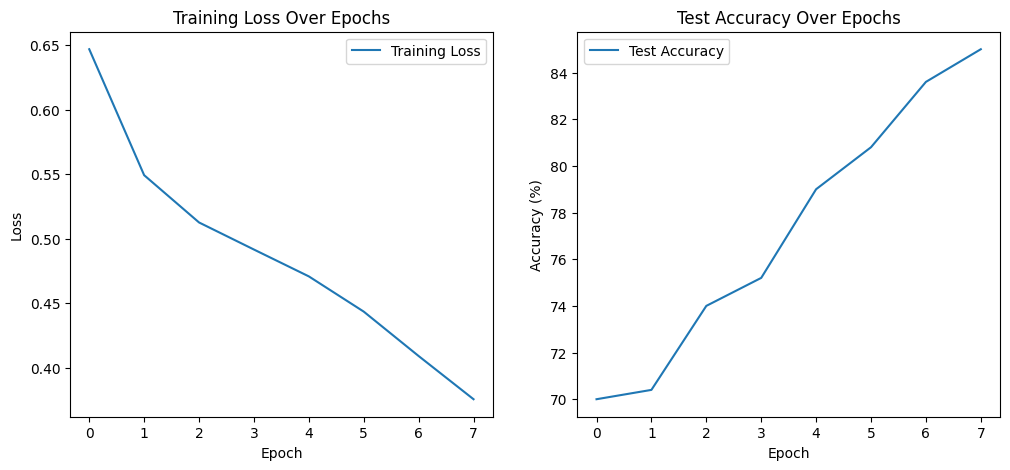

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Training Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# Test Accuracy
plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Over Epochs')
plt.legend()

plt.show()

C:\Users\MinGi\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\MinGi\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\MinGi\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 48276 (\N{HANGUL SYLLABLE BEOM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\MinGi\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51452 (\N{HANGUL SYLLABLE JU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


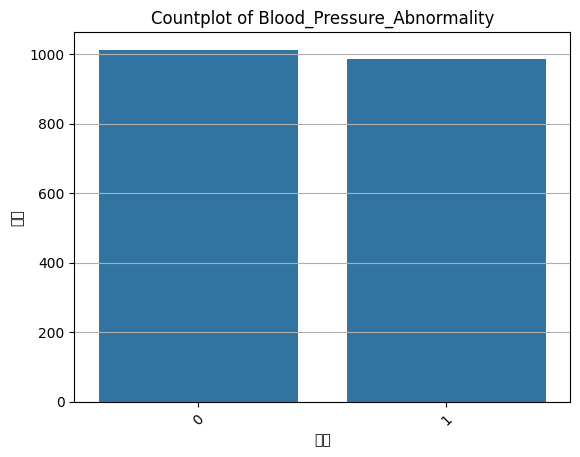

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='Blood_Pressure_Abnormality', data=df)
plt.title('Countplot of Blood_Pressure_Abnormality')
plt.xlabel('범주')
plt.ylabel('개수')
plt.xticks(rotation=45)  # 카테고리 이름이 겹칠 경우
plt.grid(True, axis='y')
plt.show()

C:\Users\MinGi\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\MinGi\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\MinGi\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 55137 (\N{HANGUL SYLLABLE HEUB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\MinGi\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 50672 (\N{HANGUL SYLLABLE YEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\MinGi\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 50

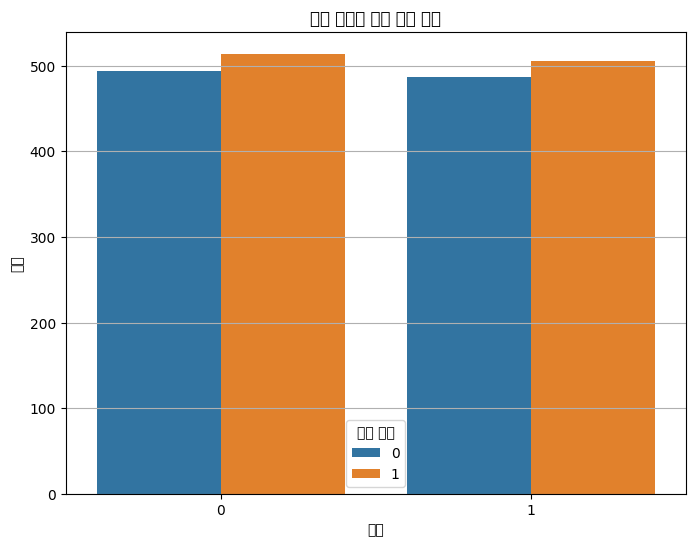

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.countplot(x='Sex', hue='Smoking', data=df)
plt.title('흡연 여부에 따른 성별 분포')
plt.xlabel('성별')
plt.ylabel('개수')
plt.legend(title='흡연 여부')
plt.grid(True, axis='y')
plt.show()

C:\Users\MinGi\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\MinGi\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\MinGi\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\MinGi\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51313 (\N{HANGUL SYLLABLE JOG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\MinGi\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 47141

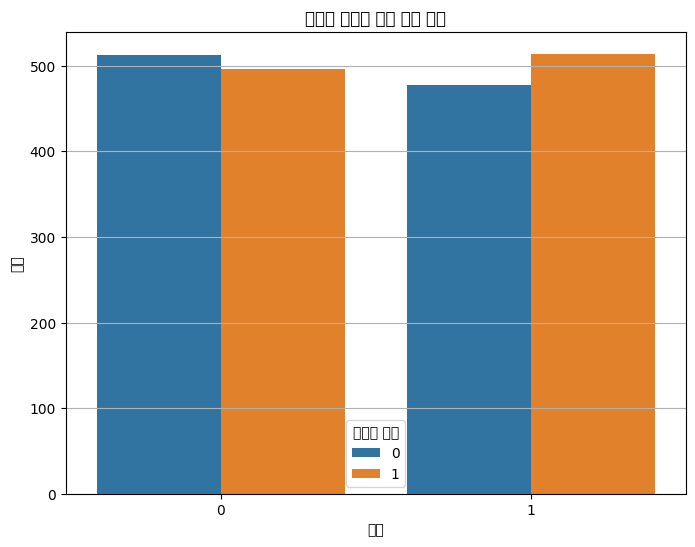

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.countplot(x='Sex', hue='Chronic_kidney_disease', data=df)
plt.title('가족력 여부에 따른 성별 분포')
plt.xlabel('성별')
plt.ylabel('개수')
plt.legend(title='가족력 여부')
plt.grid(True, axis='y')
plt.show()

C:\Users\MinGi\AppData\Local\Temp\ipykernel_30396\1329074835.py:10: UserWarning: Glyph 44050 (\N{HANGUL SYLLABLE GABS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MinGi\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44050 (\N{HANGUL SYLLABLE GABS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


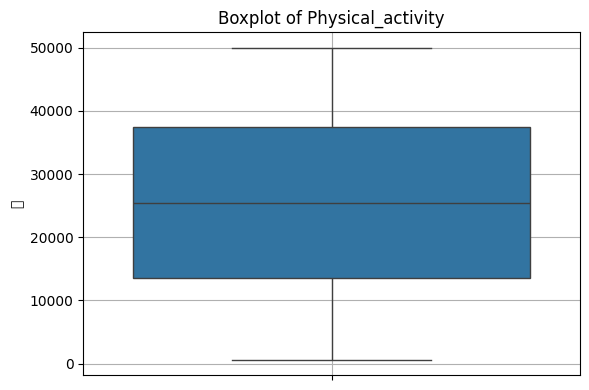

In [18]:
# 박스플롯 - 범위 확인
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.boxplot(y=df['Physical_activity'])
plt.title('Boxplot of Physical_activity')
plt.ylabel('값')
plt.grid(True)
plt.tight_layout()
plt.show()

# Q1, Q2, Q3
- out layter 제거
- Q1, Q2, Q3

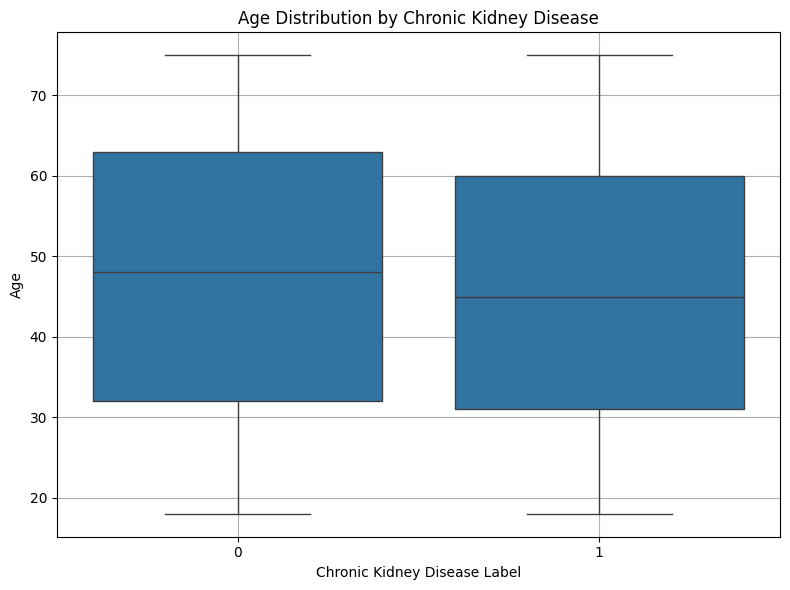

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.boxplot(x='Chronic_kidney_disease', y='Age', data=df)
plt.title('Age Distribution by Chronic Kidney Disease')
plt.xlabel('Chronic Kidney Disease Label')
plt.ylabel('Age')
plt.grid(True)
plt.tight_layout()
plt.show()


### 바이올릿 플롯

C:\Users\MinGi\AppData\Local\Temp\ipykernel_30396\1785325181.py:10: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MinGi\AppData\Local\Temp\ipykernel_30396\1785325181.py:10: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MinGi\AppData\Local\Temp\ipykernel_30396\1785325181.py:10: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MinGi\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\MinGi\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\MinGi\AppData\Roaming\P

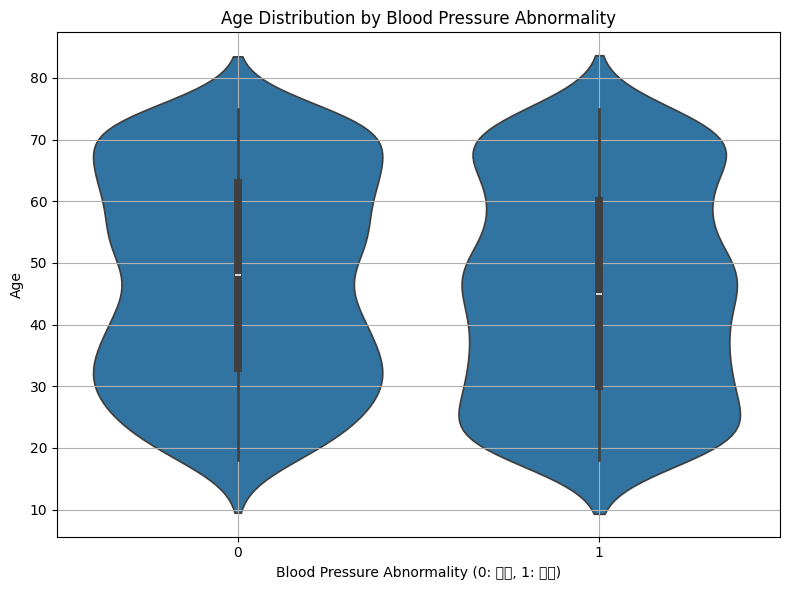

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.violinplot(x='Blood_Pressure_Abnormality', y='Age', data=df, inner='box')
plt.title('Age Distribution by Blood Pressure Abnormality')
plt.xlabel('Blood Pressure Abnormality (0: 정상, 1: 이상)')
plt.ylabel('Age')
plt.grid(True)
plt.tight_layout()
plt.show()


### 히트맵
- 0.3 이상이면 유의미
- 상관관계를 보기 위해 많이 사용

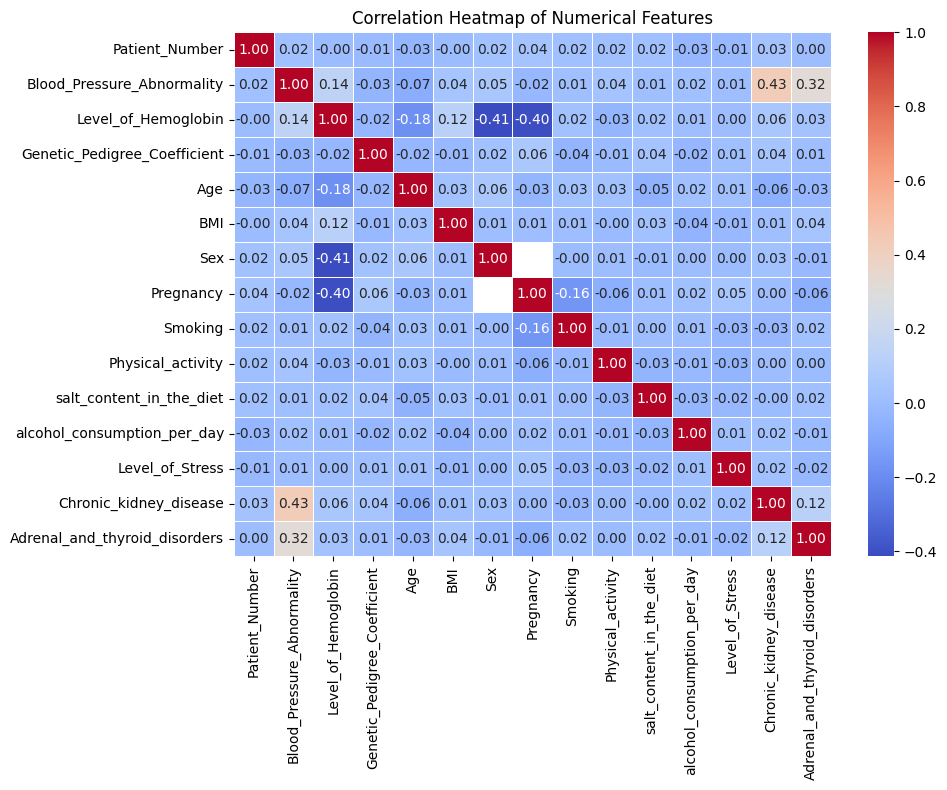

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# 수치형 변수만 추출
num_cols = df.select_dtypes(include=['int64', 'float64'])

# 상관계수 행렬 계산
corr = num_cols.corr()

# 히트맵 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Features')
plt.tight_layout()
plt.show()


### 히스토그램
- 데이터의 분포를 보기 위해 사용

C:\Users\MinGi\AppData\Local\Temp\ipykernel_30396\1705973870.py:9: UserWarning: Glyph 44050 (\N{HANGUL SYLLABLE GABS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MinGi\AppData\Local\Temp\ipykernel_30396\1705973870.py:9: UserWarning: Glyph 48712 (\N{HANGUL SYLLABLE BIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MinGi\AppData\Local\Temp\ipykernel_30396\1705973870.py:9: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MinGi\AppData\Local\Temp\ipykernel_30396\1705973870.py:9: UserWarning: Glyph 52972 (\N{HANGUL SYLLABLE KEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MinGi\AppData\Local\Temp\ipykernel_30396\1705973870.py:9: UserWarning: Glyph 47100 (\N{HANGUL SYLLABLE REOM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MinGi\AppData\Local\Temp\ipykernel_30396\1705973870.py:9: UserWarning: Glyph 47749 (\N{HANGUL SYLLABLE MYEONG}) missing from

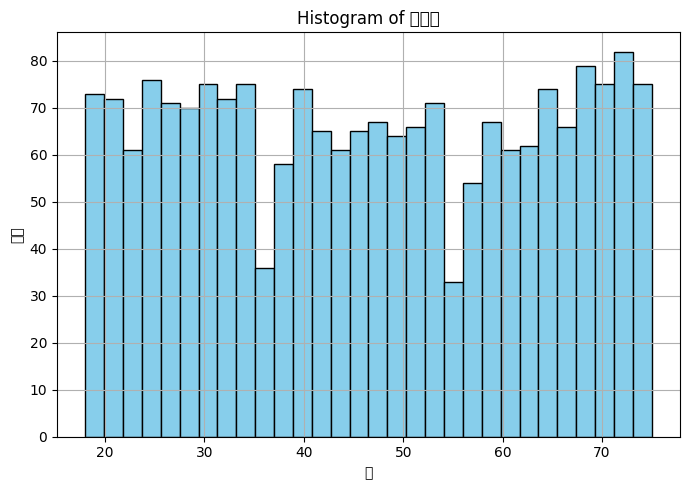

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5))
plt.hist(df['Age'].dropna(), bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of 컬럼명')
plt.xlabel('값')
plt.ylabel('빈도')
plt.grid(True)
plt.tight_layout()
plt.show()


### kde 디스플롯

C:\Users\MinGi\AppData\Local\Temp\ipykernel_30396\863661850.py:10: UserWarning: Glyph 44050 (\N{HANGUL SYLLABLE GABS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MinGi\AppData\Local\Temp\ipykernel_30396\863661850.py:10: UserWarning: Glyph 48128 (\N{HANGUL SYLLABLE MIL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MinGi\AppData\Local\Temp\ipykernel_30396\863661850.py:10: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MinGi\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 48128 (\N{HANGUL SYLLABLE MIL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\MinGi\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\MinGi\AppData\Roaming\Python\Py

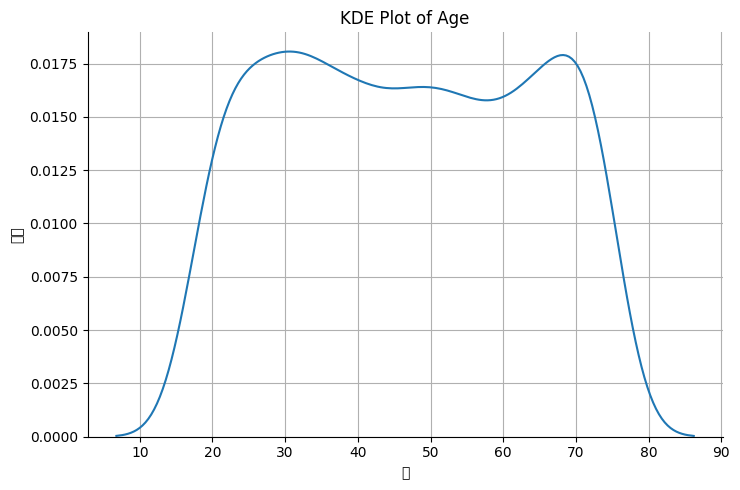

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# 기본 KDE 플롯
sns.displot(data=df, x='Age', kind='kde', height=5, aspect=1.5)
plt.title('KDE Plot of Age')
plt.xlabel('값')
plt.ylabel('밀도')
plt.grid(True)
plt.tight_layout()
plt.show()

### 산정도
- 교재 98p 참고
- 2개 컬럼의 상관관계

C:\Users\MinGi\AppData\Local\Temp\ipykernel_30396\2447643416.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x='Blood_Pressure_Abnormality', y='Age', data=df, jitter=True, palette='Set2')
C:\Users\MinGi\AppData\Local\Temp\ipykernel_30396\2447643416.py:10: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MinGi\AppData\Local\Temp\ipykernel_30396\2447643416.py:10: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MinGi\AppData\Local\Temp\ipykernel_30396\2447643416.py:10: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MinGi\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51221 (\N{HANGUL SY

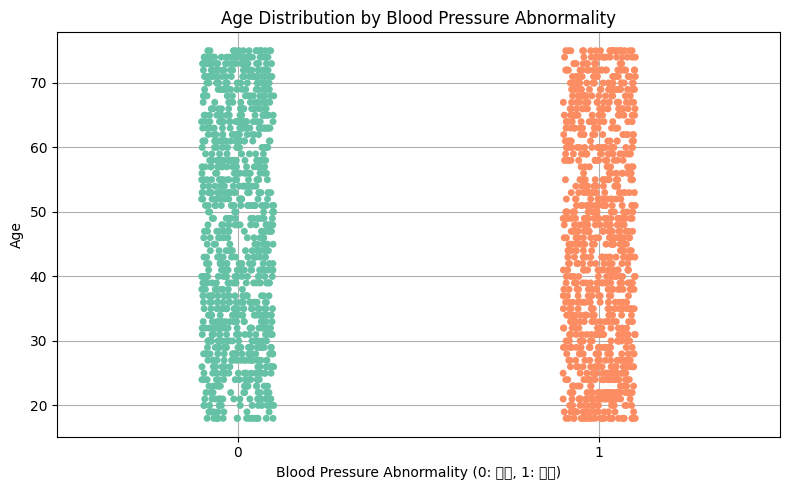

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.stripplot(x='Blood_Pressure_Abnormality', y='Age', data=df, jitter=True, palette='Set2')
plt.title('Age Distribution by Blood Pressure Abnormality')
plt.xlabel('Blood Pressure Abnormality (0: 정상, 1: 이상)')
plt.ylabel('Age')
plt.grid(True)
plt.tight_layout()
plt.show()

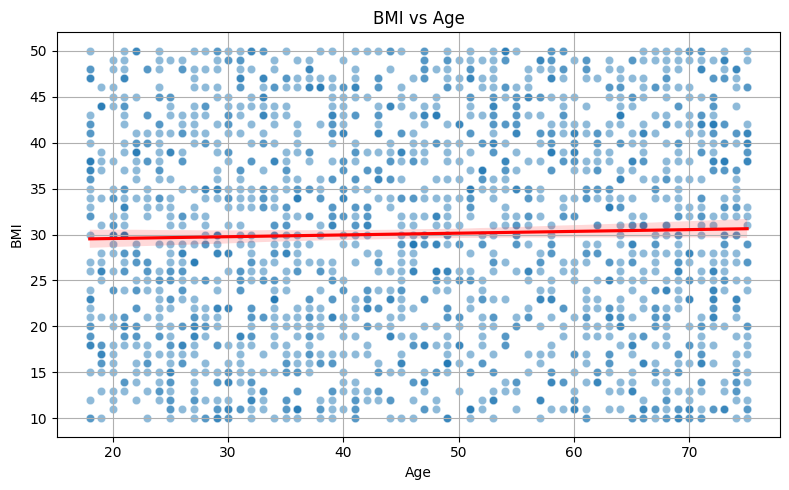

In [26]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x='Age', y='BMI', data=df, alpha=0.5)
sns.regplot(x='Age', y='BMI', data=df, scatter=False, color='red')  # 회귀선 추가
plt.title('BMI vs Age')
plt.xlabel('Age')
plt.ylabel('BMI')
plt.grid(True)
plt.tight_layout()
plt.show()


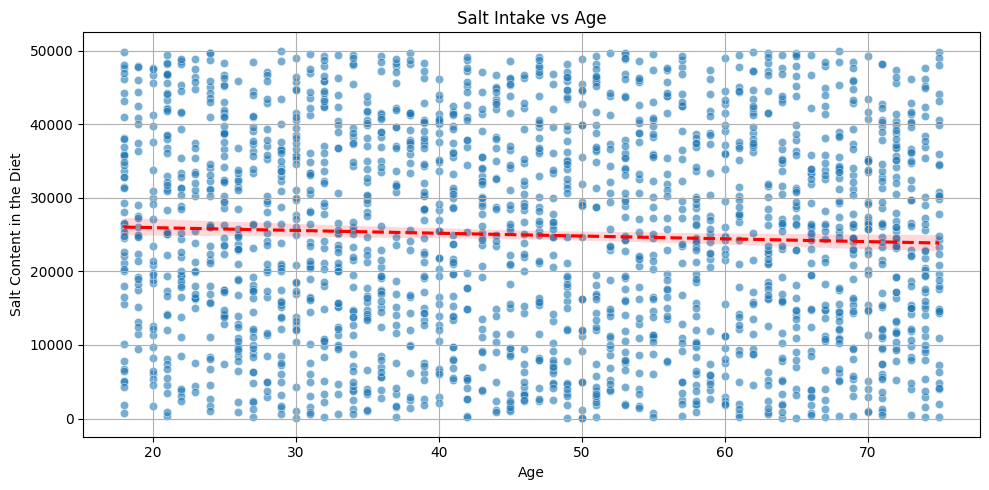

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.scatterplot(data=df, x='Age', y='salt_content_in_the_diet', alpha=0.6)
sns.regplot(data=df, x='Age', y='salt_content_in_the_diet', scatter=False, color='red', line_kws={"linestyle": "--"})
plt.title('Salt Intake vs Age')
plt.xlabel('Age')
plt.ylabel('Salt Content in the Diet')
plt.grid(True)
plt.tight_layout()
plt.show()


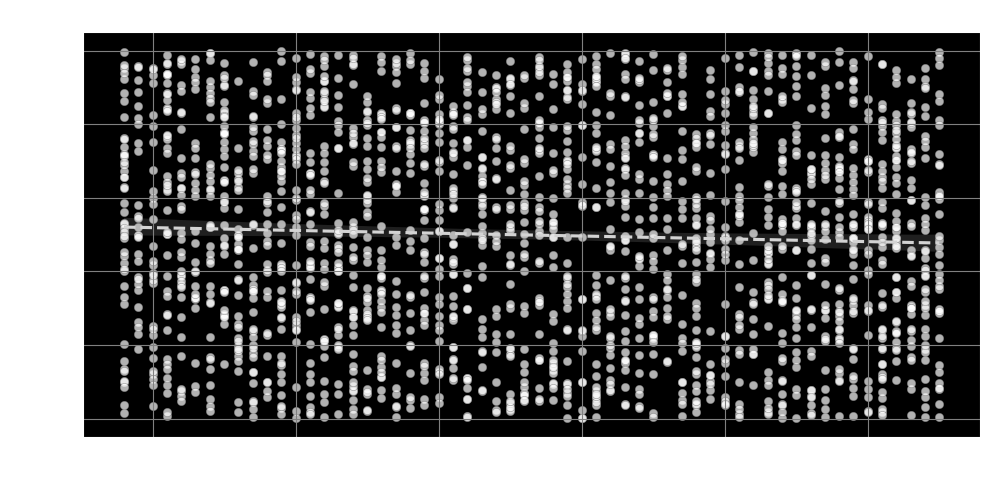

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# 기본 산점도 + 회귀선 (흑백 반전)
plt.figure(figsize=(10, 5))
plt.style.use('dark_background')  # 💡 흑백 반전 핵심

sns.scatterplot(data=df, x='Age', y='salt_content_in_the_diet', color='white', edgecolor='gray', alpha=0.7)
sns.regplot(data=df, x='Age', y='salt_content_in_the_diet', scatter=False, color='lightgray', line_kws={'linestyle': '--'})

plt.title('Salt Intake vs Age', color='white')
plt.xlabel('Age', color='white')
plt.ylabel('Salt Content in the Diet', color='white')
plt.grid(True, color='gray')
plt.tick_params(colors='white')  # 축 눈금 색
plt.tight_layout()
plt.show()

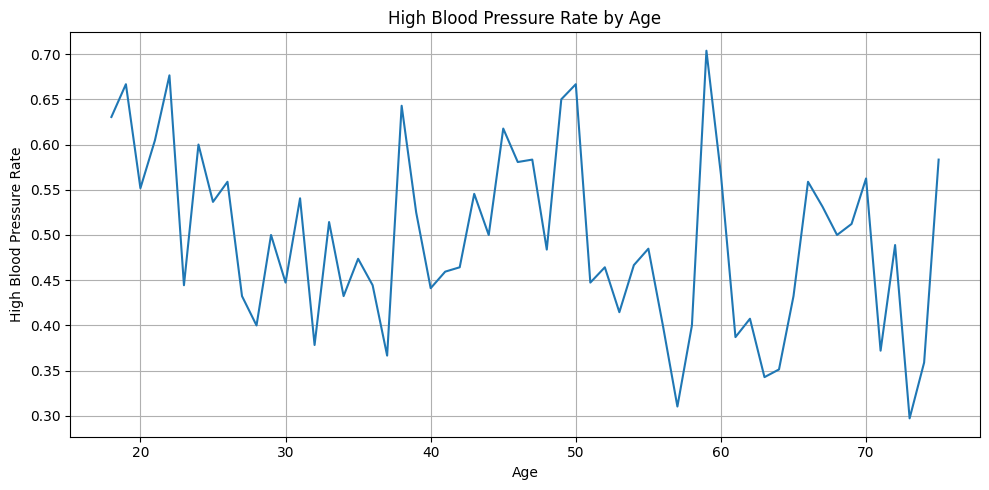

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# 나이 기준으로 평균 고혈압률 계산
age_bp = df.groupby('Age')['Blood_Pressure_Abnormality'].mean().reset_index()

plt.figure(figsize=(10, 5))
sns.lineplot(data=age_bp, x='Age', y='Blood_Pressure_Abnormality')
plt.title('High Blood Pressure Rate by Age')
plt.xlabel('Age')
plt.ylabel('High Blood Pressure Rate')
plt.grid(True)
plt.tight_layout()
plt.show()

### 점선 그래프

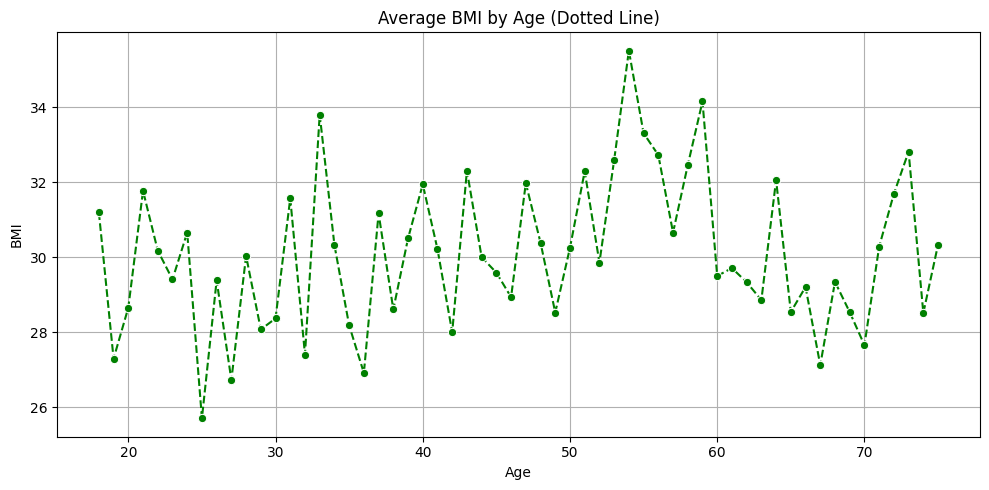

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# 예: 나이별 평균 BMI
age_bmi = df.groupby('Age')['BMI'].mean().reset_index()

plt.figure(figsize=(10, 5))
sns.lineplot(data=age_bmi, x='Age', y='BMI', linestyle='--', marker='o', color='green')
plt.title('Average BMI by Age (Dotted Line)')
plt.xlabel('Age')
plt.ylabel('BMI')
plt.grid(True)
plt.tight_layout()
plt.show()


### 막대그래프

C:\Users\MinGi\AppData\Local\Temp\ipykernel_30396\599381991.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bp_bmi, x='Blood_Pressure_Abnormality', y='BMI', palette='pastel')


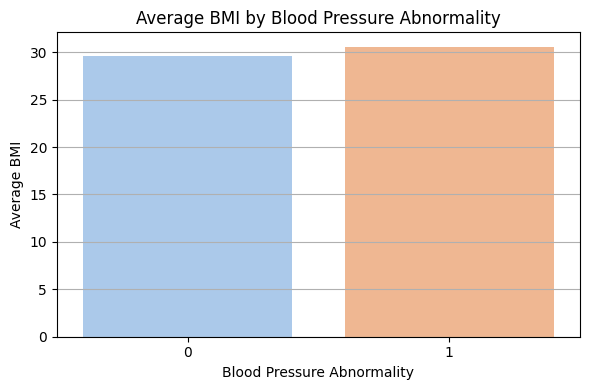

In [29]:
# 예: 고혈압 여부에 따른 평균 BMI
bp_bmi = df.groupby('Blood_Pressure_Abnormality')['BMI'].mean().reset_index()

plt.figure(figsize=(6, 4))
sns.barplot(data=bp_bmi, x='Blood_Pressure_Abnormality', y='BMI', palette='pastel')
plt.title('Average BMI by Blood Pressure Abnormality')
plt.xlabel('Blood Pressure Abnormality')
plt.ylabel('Average BMI')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


---

In [8]:
x = df.drop('Chronic_kidney_disease', axis=1)
y = df['Chronic_kidney_disease']

In [11]:
scaler = StandardScaler()
x = scaler.fit_transform(x)

In [14]:
Y = pd.get_dummies(y).values

x_train, x_test, y_train, y_test = train_test_split(x, Y,test_size=0.25,random_state=0)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(1500, 14) (1500, 2)
(500, 14) (500, 2)
